In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv'
usecols = range(6)
merged = pd.read_csv(fpath, index_col=0, skiprows=1, usecols=usecols).rename_axis('drug_chembl_id', axis=0)

In [3]:
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv'
sel_gsets = ['knowledge', 'TWAS2+', 'agora2+', 'AD DE APOE3-APOE3', 'AD DE APOE4-APOE4', 'APOE3-4 DE neuron', 'APOE3-4 DE astrocyte', 'APOE3-4 DE microglia']
merged_ranks = pd.read_csv(fpath, index_col=0, header=[0, 1]).rename_axis('drug_chembl_id', axis=0).xs('rank', axis=1, level=1)[sel_gsets]

In [4]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-indication.csv'
indications = pd.read_csv(fpath, index_col='drug_chembl_id')
# D000544 is Alzheimer disease
mp4ad = indications.loc[indications.mesh_id == 'D000544', ['max_phase_for_ind']].rename({'max_phase_for_ind': 'max_phase_for_AD'}, axis=1)

In [5]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-info-bbb.csv'
info_bbb = pd.read_csv(fpath, index_col=0).drop(['drug_name'], axis=1)

In [6]:
fpath = '../../results/2022-01-14-rank-aggregation/aggregated-ranks.csv'
agg_ranks = pd.read_csv(fpath, index_col='rank')
top_drugs = pd.DataFrame({'aggregate rank': agg_ranks.index}, index=agg_ranks.MC3).rename_axis('drug_chembl_id', axis=0)

In [7]:
drugs = pd.merge(merged, info_bbb, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, mp4ad, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, top_drugs, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, merged_ranks, how='left', on='drug_chembl_id')
drugs = drugs.sort_values('aggregate rank')
drugs.to_csv('../../results/2022-01-14-top-drugs/ranked-drugs.csv')

In [8]:
def top_bottom(drugs=drugs, topk=100, min_max_phase_for_AD=1):
    bottomk = len(drugs) - topk
    df = drugs.copy()
    df['tested4AD'] = drugs.max_phase_for_AD >= min_max_phase_for_AD
    top = df.iloc[:topk]
    bottom = df.iloc[topk:]
    top_avg, bottom_avg = [df.loc[df['tested4AD'], 'max_phase_for_AD'].sum() / xk for df, xk in zip([top, bottom], [topk, bottomk])]
    ratio = top_avg / bottom_avg
    return(ratio)

Let $X$ denote the top-$k$ drugs or the bottom $n-k$ drugs.  Definition of **average phase for AD** for drugs in $X$:
\begin{eqnarray}
\bar{\phi_X} &=& \frac{1}{|X|} \sum_{d \in X} \phi_d \\
|X| &=& 
  \begin{cases} 
   k   & \text{if } X = \text{top-}k \text{ drugs} \\
   n-k & \text{if } X = \text{bottom } \text{ drugs}
  \end{cases}
\end{eqnarray}

Definition of **top:bottom phase ratio for AD**:
\begin{equation}
\frac{\bar{\phi}_{\text{top-}k \text{ drugs}}}{\bar{\phi}_\text{bottom drugs}}
\end{equation}

['named-figure/top-bottom-ratio-top-k.png',
 'named-figure/top-bottom-ratio-top-k.pdf']

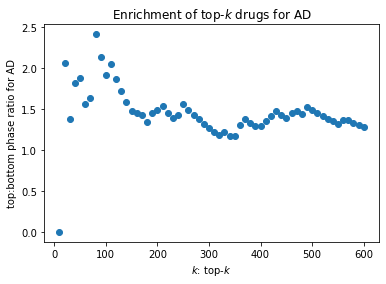

In [9]:
step = 10
topks = np.arange(start=step, stop=len(agg_ranks), step=step)
ORs = [top_bottom(drugs, topk=k, min_max_phase_for_AD=1) for k in topks]
fig, ax = plt.subplots()
ax.scatter(x=topks, y=ORs)
ax.set_xlabel(r'$k$: top-$k$')
ax.set_ylabel('top:bottom phase ratio for AD')
ax.set_title(r'Enrichment of top-$k$ drugs for AD')
attila_utils.savefig(fig, 'top-bottom-ratio-top-k')

In [10]:
%connect_info

{
  "shell_port": 52124,
  "iopub_port": 52125,
  "stdin_port": 52126,
  "control_port": 52128,
  "hb_port": 52127,
  "ip": "127.0.0.1",
  "key": "837b22aa-6284b7c393e08a165b23190e",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9dc2acaa-dd9e-47f8-8473-80bf157cbe8e.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
